In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

sys.path.append("../")
import covid19_ode_inference as cov19_ode

/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
id_func = lambda x: x
remove_beg_end = lambda x: x[1:-1]
data1 = np.loadtxt("example1.csv", skiprows=1, delimiter=",", converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
data2 = np.loadtxt("example1_SIR.csv", skiprows=1, delimiter=",")#, converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
N=100_000
cases_data = data1[:, 2]
t_cases_data = np.arange(len(cases_data))
seropos_data = data2[:, 3]/N
t_seropos_data = np.array([1,75,180])
seropos_data_subs = seropos_data[t_seropos_data]
len_sim = len(cases_data)
time=t_cases_data

In [3]:
model = cov19_ode.examples.model_cases_seropositivity(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    sim_model=False,
    fact_subs=8,
    num_cps_reporting=6,
    num_cps_R = 6,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode="JAX")
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode="JAX")
dlogp_fn(ip)
print("Timing JAX compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode='FAST_RUN')
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode='FAST_RUN')
dlogp_fn(ip)
print("Timing C compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)
;

Timing JAX compiled:
370 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
439 µs ± 6.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Timing C compiled:
543 µs ± 6.42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.21 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


''

In [23]:
def get_initial_random_points(num_chains):
    num_tries = 1000
    init = pm.sample_prior_predictive(num_tries , model=model, return_inferencedata=True)
    points_with_nan = np.unique(np.argwhere(np.isnan(np.array(init.prior_predictive["new_reported_data"])))[:,1])
    print(f"Percentage of initial_points with nans: {len(points_with_nan)/num_tries:.0%}")
    init_dict = []
    for chain in range(num_tries):
        if chain not in points_with_nan:
            init_dict.append({key: np.array(val)[0, chain] for (key, val) in init.prior.items() })
        if len(init_dict) == num_chains:
            break
    else: 
        raise RuntimeError("Not enough initial points without nans")
    return init_dict

In [30]:
num_chains = 4

init_dict = get_initial_random_points(num_chains)
trace = pm.sample(
    model=model,
    tune=500,
    draws=1000,
    cores=num_chains,
    discard_tuned_samples=False,
    nuts_sampler="numpyro",
    target_accept=0.9,
    initvals=init_dict,
    nuts_sampler_kwargs=dict(
        chain_method="parallel", 
        nuts_kwargs=dict(max_tree_depth=10, 
                         step_size=1,)
    ),
    keep_warning_stat=True,
)
warnings = pm.stats.convergence.run_convergence_checks(trace,model=model,)
pm.stats.convergence.log_warnings(warnings) 

Sampling: [Delta_rhos_R_raw, Delta_rhos_raw, Delta_t_pos_R, Delta_t_pos_rep, I_0_raw, R0, error_report, error_sero, eta_base, inv_gamma, new_reported_data, sero_data, sigma_Delta_rhos, sigma_Delta_rhos_R, transients_R_raw, transients_rep_raw]


Percentage of initial_points with nans: 56%


/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:19.610444
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:04:35.917945
Transforming variables...
Transformation time =  0:00:01.104501


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


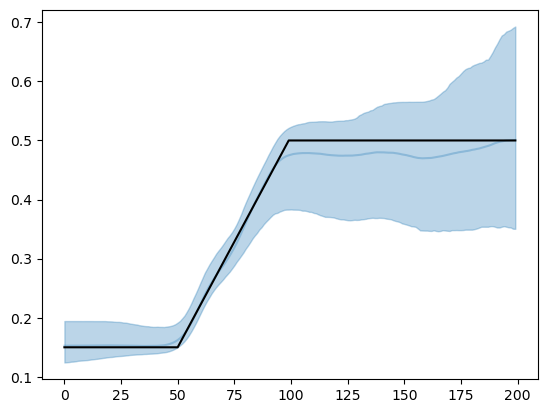

In [31]:
values_inferred = trace.posterior["eta_report"].to_numpy().reshape((-1, len_sim))

plt.plot(time, np.median(values_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(values_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 2]/data1[:, 1], color="black")

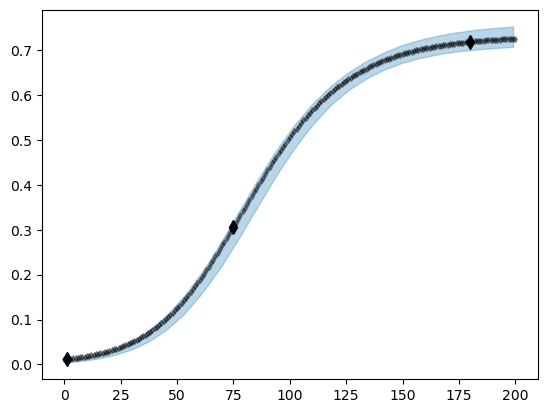

In [32]:
new_positive_inferred = trace.posterior["Sero_t"].to_numpy().reshape((-1, len_sim))

plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.plot(seropos_data, marker="d", color="black", ls="", ms=3, alpha=0.4);
plt.plot(t_seropos_data, seropos_data[t_seropos_data], marker="d", color="black", ls="", ms=7);



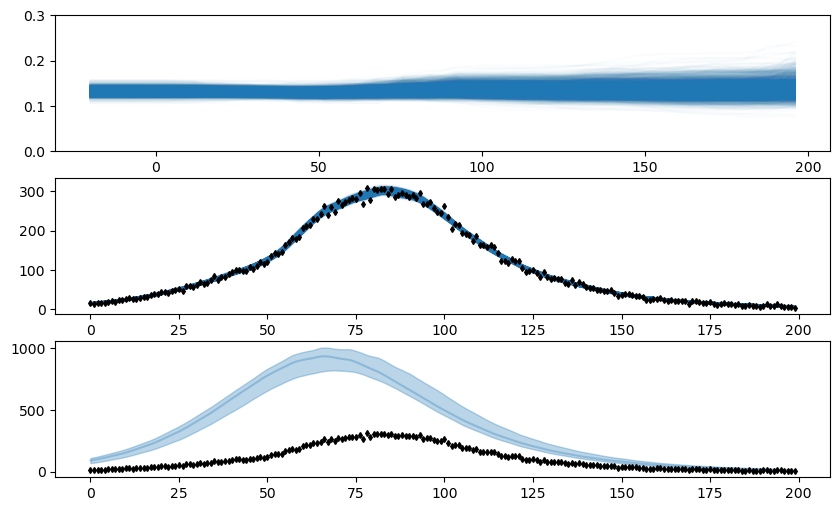

In [33]:
f, axes = plt.subplots(3,1, figsize = (10,6))
t_solve_ODE = model.coords["t_solve_ODE"]
f.sca(axes[0])
plt.plot(t_solve_ODE, trace.posterior["beta_t"].to_numpy().reshape((-1, len(t_solve_ODE))).T, color="tab:blue", alpha = 0.02);
plt.ylim(0,0.3)
f.sca(axes[1])
plt.plot(trace.posterior["new_reported"].to_numpy().reshape((-1, len_sim)).T, color="tab:blue", alpha = 0.02);
plt.plot(cases_data, marker="d", color="black", ls="", ms=3);
f.sca(axes[2])

new_positive_inferred = trace.posterior["new_positive"].to_numpy().reshape((-1, len_sim))
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(cases_data, marker="d", color="black", ls="", ms=3);



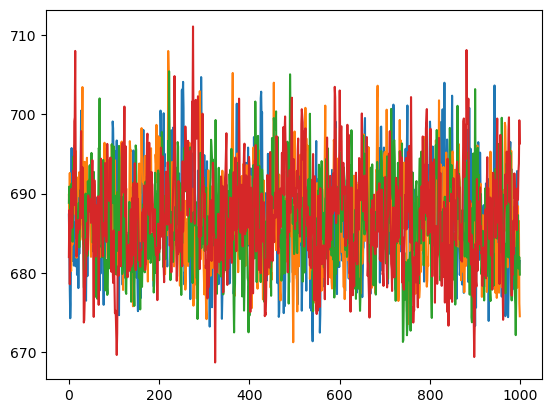

In [40]:
plt.plot(trace.sample_stats["lp"].T);

<xarray.DataArray 'tree_depth' (chain: 4)>
array([9.033, 8.997, 9.006, 9.073])
Coordinates:
  * chain    (chain) int64 0 1 2 3

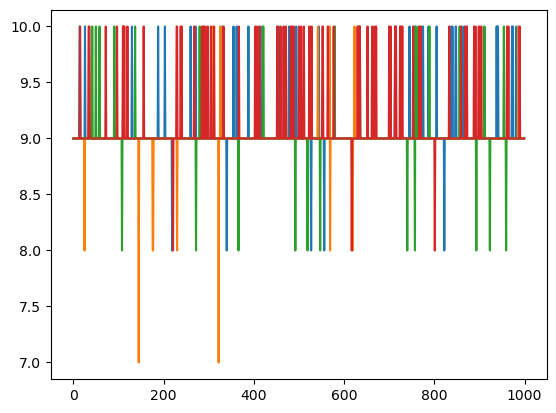

In [38]:
plt.plot(trace.sample_stats["tree_depth"].T);
np.mean(trace.sample_stats["tree_depth"], axis=1)

In [39]:
import arviz as az
rhat = az.rhat(trace)
rhat.max()

/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset>
Dimensions:             ()
Data variables: (12/30)
    eta_base            float64 1.003
    Delta_t_pos_rep     float64 1.01
    Delta_rhos_raw      float64 1.01
    transients_rep_raw  float64 1.007
    Delta_t_pos_R       float64 1.004
    Delta_rhos_R_raw    float64 1.005
    ...                  ...
    S                   float64 1.007
    I                   float64 1.007
    R                   float64 1.006
    new_positive        float64 1.008
    new_reported        float64 1.01
    Sero_t              float64 1.005